## Predicting Loan Default

The dataset has the following columns :

* BAD: 1 =client defaulted on loan; 0 = loan repaid
* LOAN: Amount of the loan request
* MORTDUE : Amount due on existing mortgage
* VALUE : Value of current property
* REASONDebtCon : debt consolidation HomeImp = home improvement
* JOB: Six occupational categories
* YOJ: Years at present job

* DEROG: Number of major derogatory reports.(A derogatory item is considered negative, and typically indicates a serious delinquency or late payments. Derogatory items represent credit risk to lenders)

* DELINQ: Number of delinquent credit lines (greater the number of delinquent credit lines greater will be the probablity of default)

* CLAGE: Age of oldest trade line in months
* NINQ: Number of recent credit lines
* CLNO: Number of credit lines 
* DEBTINC: Debt-to-income ratio

#### Importing the required libraries and understanding the data

In [1]:
import pandas as pd
import numpy as np

In [2]:
df= pd.read_csv(r"C:\Users\shubh\Downloads\datasets\hmeq-data\hmeq.csv")

In [3]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [4]:
df.shape

(5960, 13)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
BAD        5960 non-null int64
LOAN       5960 non-null int64
MORTDUE    5442 non-null float64
VALUE      5848 non-null float64
REASON     5708 non-null object
JOB        5681 non-null object
YOJ        5445 non-null float64
DEROG      5252 non-null float64
DELINQ     5380 non-null float64
CLAGE      5652 non-null float64
NINQ       5450 non-null float64
CLNO       5738 non-null float64
DEBTINC    4693 non-null float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


#### Treating the missing values and observing the unique values in the two categorical column.

In [6]:
df['JOB'].value_counts()

Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: JOB, dtype: int64

In [7]:
df['REASON'].value_counts()

DebtCon    3928
HomeImp    1780
Name: REASON, dtype: int64

In [8]:
df.isnull().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

In [9]:
# count the number of rows having > 5 missing values
len(df[df.isnull().sum(axis=1) > 5].index)

192

In [10]:
print(round(100*(df.isnull().sum()/len(df.index)),2))

BAD         0.00
LOAN        0.00
MORTDUE     8.69
VALUE       1.88
REASON      4.23
JOB         4.68
YOJ         8.64
DEROG      11.88
DELINQ      9.73
CLAGE       5.17
NINQ        8.56
CLNO        3.72
DEBTINC    21.26
dtype: float64


In [11]:
# retaining the rows having <= 5 NaNs
df = df[df.isnull().sum(axis=1) <= 5]

# look at the summary again
round(100*(df.isnull().sum()/len(df.index)), 2)

BAD         0.00
LOAN        0.00
MORTDUE     7.49
VALUE       1.61
REASON      2.88
JOB         2.53
YOJ         6.83
DEROG       8.96
DELINQ      6.74
CLAGE       2.08
NINQ        5.53
CLNO        0.61
DEBTINC    20.87
dtype: float64

In [12]:
# We drop the debt to income ratio because it has around 20% null values, and debt-income ratio for everyone varies significantly.
df.drop(['DEBTINC'],1, inplace=True)
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0
5,1,1700,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,101.466002,1.0,8.0


##### Since the age of the oldest trade line cannot be zero, even the Number of recent credit lines and  Number of credit lines cant be zero, we remove them

In [13]:
df.describe(percentiles=[.25, .5, .75, .90, .95, .99])

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO
count,5768.000000,5768.00000,5336.000000,5675.000000,5374.000000,5251.000000,5379.000000,5648.000000,5449.000000,5733.000000
mean,0.197469,18783.23509,73955.727489,102281.146967,8.931894,0.254618,0.449526,179.746114,1.186273,21.305774
std,0.398124,11286.37171,44673.417781,57824.897869,7.596436,0.846120,1.127354,85.783556,1.728759,10.136653
min,0.000000,1100.00000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,11200.00000,46395.000000,66208.500000,3.000000,0.000000,0.000000,115.135216,0.000000,15.000000
50%,0.000000,16500.00000,65026.000000,89720.000000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000
75%,0.000000,23500.00000,91827.250000,120145.500000,13.000000,0.000000,0.000000,231.463168,2.000000,26.000000
90%,1.000000,30930.00000,131103.000000,176158.600000,21.000000,1.000000,2.000000,295.582287,3.000000,34.000000
95%,1.000000,40300.00000,152148.750000,204312.600000,24.000000,2.000000,3.000000,321.607996,4.000000,40.000000
99%,1.000000,62566.00000,232315.250000,290010.140000,30.000000,4.000000,5.000000,399.560377,8.520000,50.000000


In [14]:
df.shape

(5768, 12)

##### We fill the null values in `DEROG`,`DELINQ` with 0 since the 75 percentile also has a value of 0 and nan could mean that a person has 0 DEROG & DELINQ

In [15]:
df['DEROG'].fillna(value= 0, inplace= True)
df['DELINQ'].fillna(value= 0, inplace= True)
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0
5,1,1700,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,101.466002,1.0,8.0


##### In columns `MORTDUE`,`VALUE`,`CLAGE` we only retain the non-null values as their null values can be ambiguous.

In [16]:
df = df[pd.notnull(df['MORTDUE'])]
df = df[pd.notnull(df['VALUE'])]
df = df[pd.notnull(df['CLAGE'])]
print(round(100*(df.isnull().sum()/len(df.index)), 2))

BAD        0.00
LOAN       0.00
MORTDUE    0.00
VALUE      0.00
REASON     2.33
JOB        2.05
YOJ        4.83
DEROG      0.00
DELINQ     0.00
CLAGE      0.00
NINQ       4.01
CLNO       0.00
dtype: float64


##### We fill the null values in `YOJ`,`JOB` & `REASON` with the mean, mode and mode respectively. Since there are extreame rise in the values from 99 percentile to max in `NINQ` &  so we replace the null values with the median.

In [17]:
df['JOB'].fillna(value= 'Other' , inplace= True)
df['YOJ'].fillna(df['YOJ'].mean() , inplace= True)
df['REASON'].fillna(value= 'DebtCon' , inplace= True)
df['NINQ'].fillna(df['YOJ'].median() , inplace= True)

In [18]:
print(round(100*(df.isnull().sum()/len(df.index)), 2))
print(df.shape)

BAD        0.0
LOAN       0.0
MORTDUE    0.0
VALUE      0.0
REASON     0.0
JOB        0.0
YOJ        0.0
DEROG      0.0
DELINQ     0.0
CLAGE      0.0
NINQ       0.0
CLNO       0.0
dtype: float64
(5160, 12)


#### Visulaising the data and seeing for the correlation among different independent variables.

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

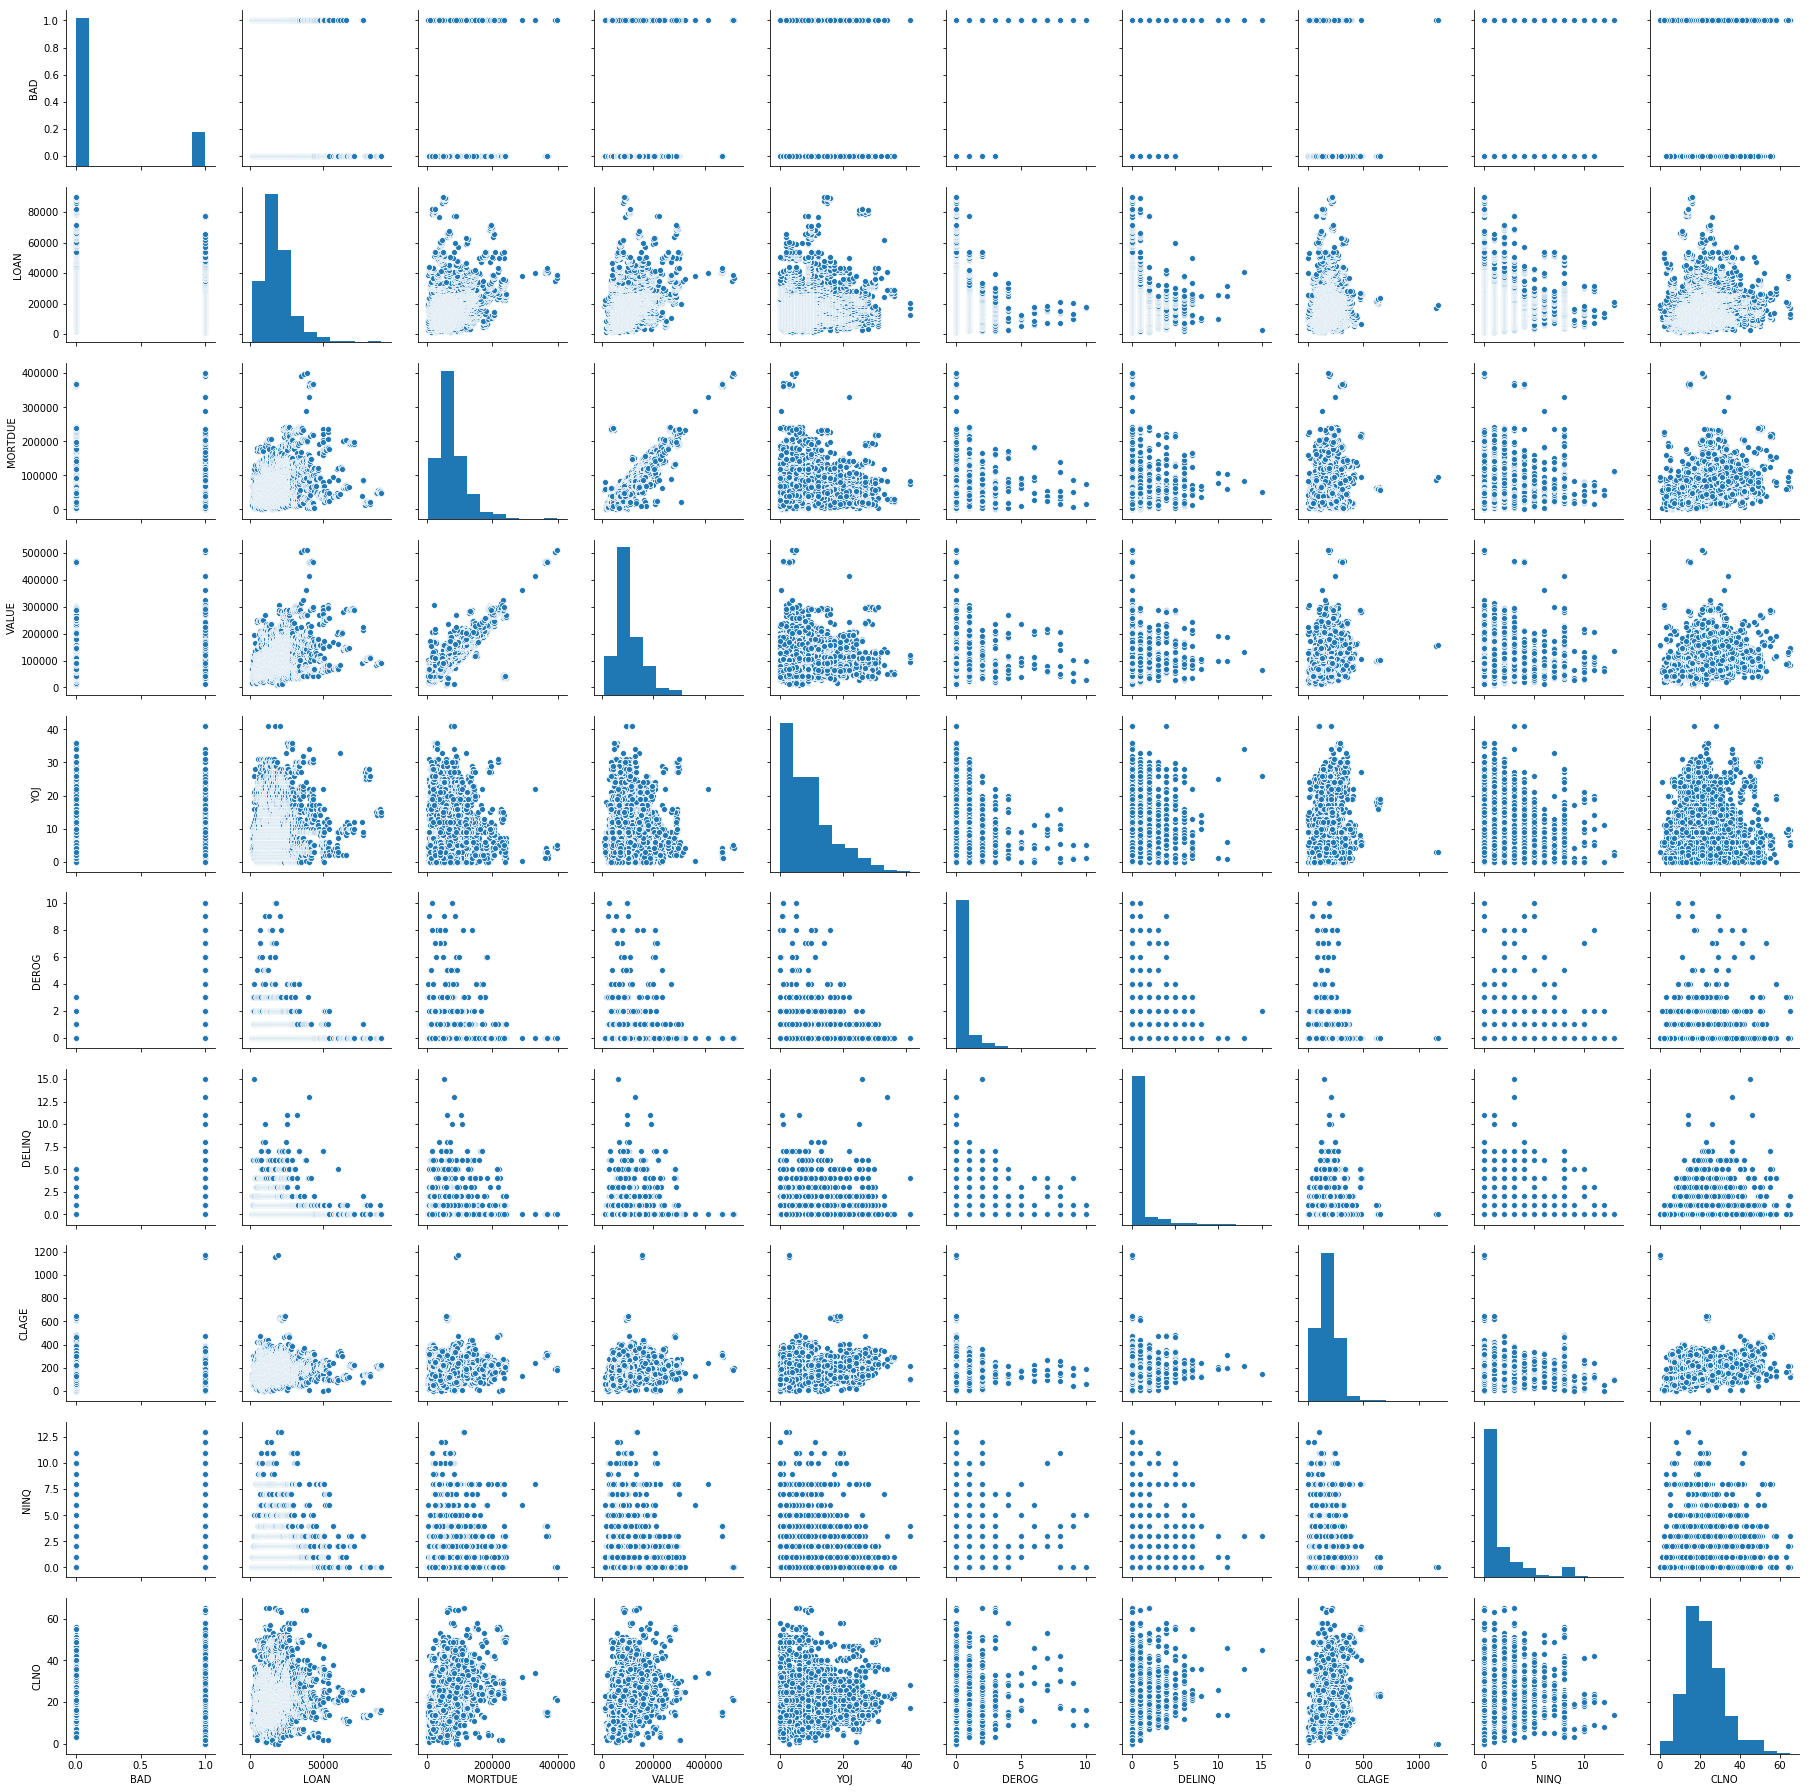

In [20]:
sns.pairplot(df)
plt.show()

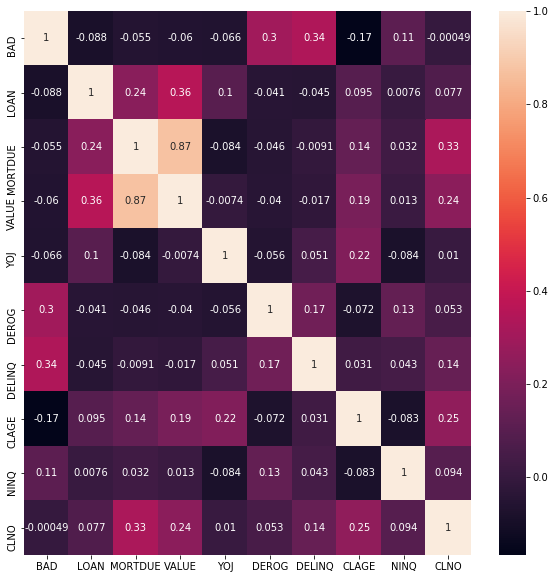

In [21]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True)

We see that the correlation between the `VALUE` and the `MORTDUE` is 0.87 so we drop any one of them, I dropped `MORTDUE` because it had a larger share of null values between the two.

In [22]:
df.drop('MORTDUE',1)
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0
5,1,1700,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,101.466002,1.0,8.0


##### We also have some categorical variable so we plot a countplot for them.

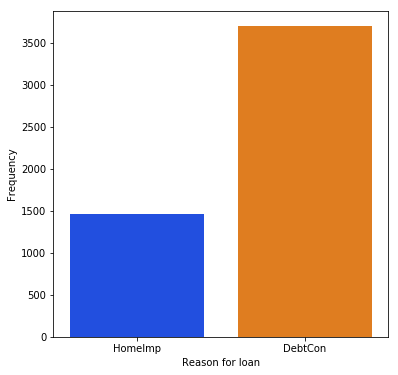

In [23]:
plt.figure(figsize=(6,6))
sns.countplot(x='REASON', data=df, palette='bright')
plt.xlabel('Reason for loan')
plt.ylabel('Frequency')
plt.show()

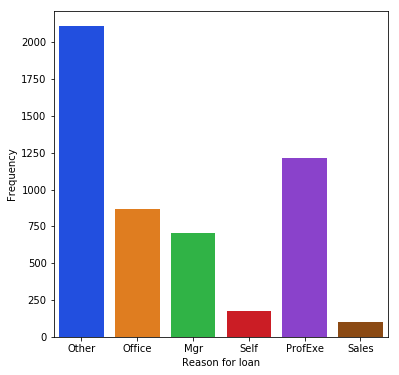

In [24]:
plt.figure(figsize=(6,6))
sns.countplot(x='JOB', data=df, palette='bright')
plt.xlabel('Reason for loan')
plt.ylabel('Frequency')
plt.show()

#### We create dummies for the categorical variable.

In [25]:
df= pd.get_dummies(data= df, columns= ['REASON', 'JOB'], drop_first=True)

In [26]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,REASON_HomeImp,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1100,25860.0,39025.0,10.5,0.0,0.0,94.366667,1.0,9.0,1,0,1,0,0,0
1,1,1300,70053.0,68400.0,7.0,0.0,2.0,121.833333,0.0,14.0,1,0,1,0,0,0
2,1,1500,13500.0,16700.0,4.0,0.0,0.0,149.466667,1.0,10.0,1,0,1,0,0,0
4,0,1700,97800.0,112000.0,3.0,0.0,0.0,93.333333,0.0,14.0,1,1,0,0,0,0
5,1,1700,30548.0,40320.0,9.0,0.0,0.0,101.466002,1.0,8.0,1,0,1,0,0,0


### Train-Test Split

In [27]:
from sklearn.model_selection import train_test_split


In [28]:
X = df.drop(['BAD'],axis=1)

In [29]:
y = df['BAD']
y.head()

0    1
1    1
2    1
4    0
5    1
Name: BAD, dtype: int64

In [30]:
X_train, X_test, y_train, y_test,= train_test_split(X,y, train_size= 0.7, test_size= 0.3, random_state= 100)

### Feature Scaling

In [31]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
scaler= MinMaxScaler()

In [33]:
list_=['LOAN','MORTDUE','VALUE','YOJ','DEROG','DELINQ','CLAGE','NINQ','CLNO']

X_train[list_] = scaler.fit_transform(X_train[list_])

X_train.head()

C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\shubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\shubh\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = 

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,REASON_HomeImp,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
5367,0.332207,0.577027,0.543314,0.170732,0.0,0.066667,0.173363,0.000000,0.446154,0,0,0,1,0,0
4958,0.282658,0.118938,0.129431,0.560976,0.0,0.066667,0.244970,0.000000,0.446154,0,0,1,0,0,0
2811,0.164414,0.141807,0.153264,0.707317,0.0,0.000000,0.181304,0.000000,0.323077,0,1,0,0,0,0
4470,0.250000,0.149574,0.180733,0.439024,0.0,0.000000,0.556179,0.076923,0.369231,1,0,0,1,0,0
5259,0.309685,0.092981,0.126898,0.292683,0.1,0.000000,0.073295,0.461538,0.230769,0,0,0,0,0,0


In [34]:
### Checking the % of day having when it rained tommorow
BAD = (sum(df['BAD'])/len(df['BAD'].index))*100
BAD

18.468992248062015

###  Looking at Correlations

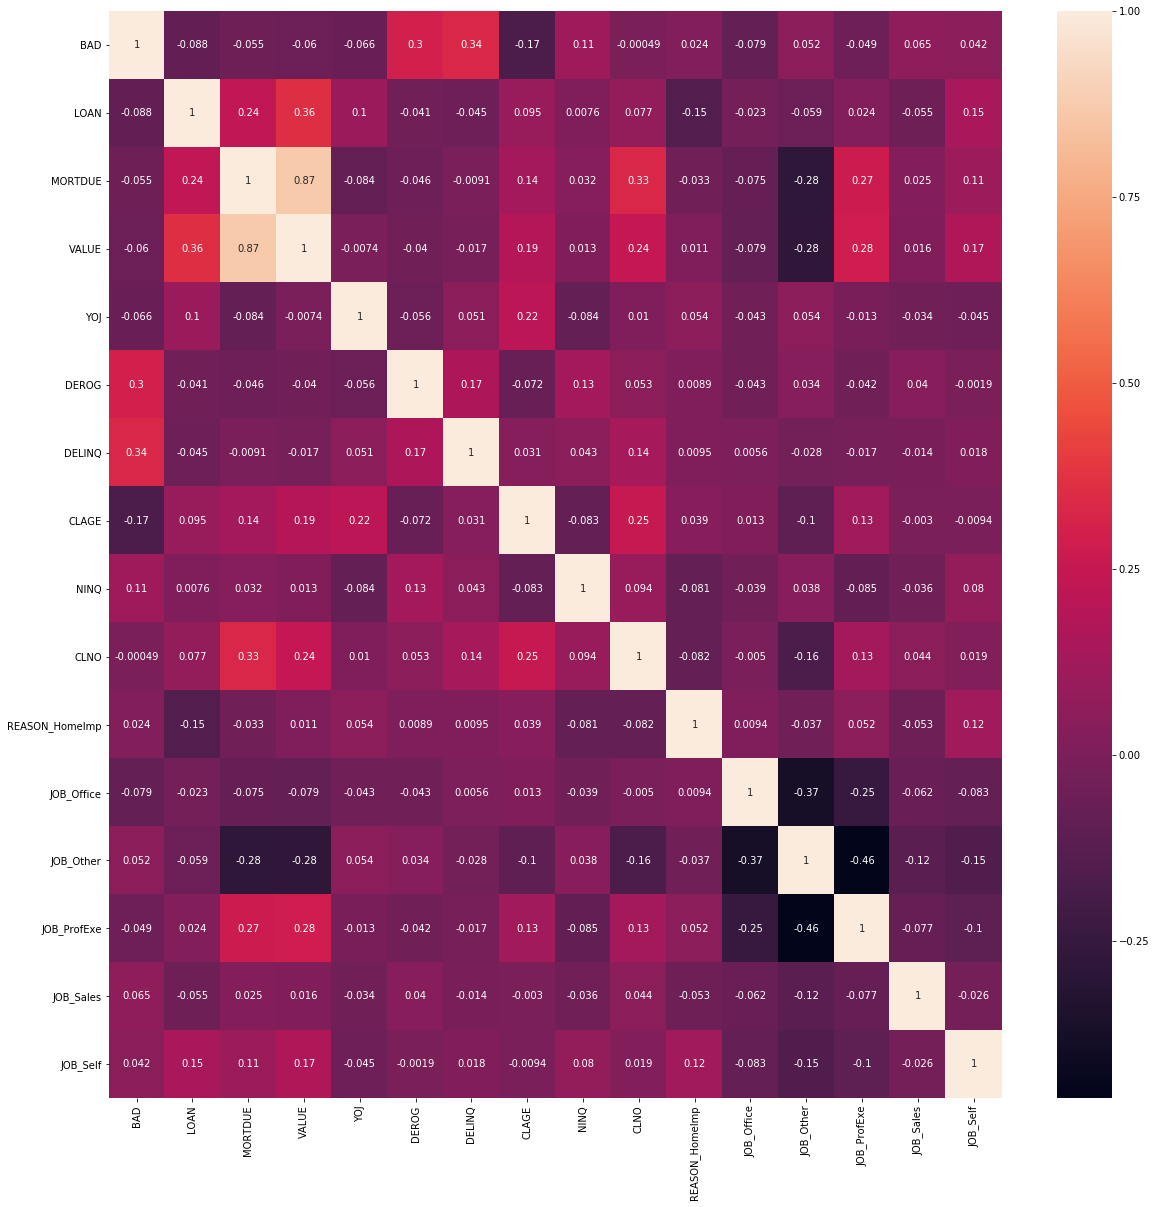

In [35]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,20))
sns.heatmap(df.corr(),annot =True)
plt.show()

##### There's no high correlation between the dummy variables so we proceed with our model building

###  Model Building
#### Running Your First Training Model

In [36]:
import statsmodels.api as sm

In [37]:
# Logistic regression model
X_train_sm= sm.add_constant(X_train)
logm1 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    BAD   No. Observations:                 3611
Model:                            GLM   Df Residuals:                     3595
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1381.2
Date:                Mon, 15 Jul 2019   Deviance:                       2762.3
Time:                        00:05:03   Pearson chi2:                 1.37e+04
No. Iterations:                     6   Covariance Type:             nonrobust
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.6939      0.216     -3.205      0.001      -1.118      -0.270
LOAN              -0.5170      0.472     -1.095      0.273      -1.442       0.408
MORTDUE           -0.6710      0.980     -0.684      0.494      -2.593       1.250
VALUE              0.7697      1.034      0.744      0.457      -1.258       2.797
YOJ               -0.7698      0.313     -2.456      0.014      -1.384      -0.156
DEROG              8.4988      0.783     10.861      0.000       6.965      10.033
DELINQ            11.2123      0.727     15.421      0.000       9.787      12.637
CLAGE             -7.8698      0.858     -9.170      0.000      -9.552      -6.188
NINQ               0.7494      0.275      2.721      0.007       0.210       1.289
CLNO              -0.3483      0.364     -0.957      0.338      -1.061       0.365
REASON_HomeImp     0.0871      0.112      0.778      0.437      -0.132       0.307
JOB_Office        -0.5611      0.193     -2.902      0.004      -0.940      -0.182
JOB_Other          0.0572      0.150      0.383      0.702      -0.236       0.350
JOB_ProfExe       -0.1116      0.172     -0.651      0.515      -0.448       0.225
JOB_Sales          0.9407      0.316      2.972      0.003       0.320       1.561
JOB_Self           0.5145      0.278      1.851      0.064      -0.030       1.059
==================================================================================
"""

#### Feature Selection Using RFE

In [38]:
from sklearn.linear_model import LogisticRegression

logreg= LogisticRegression()

In [39]:
from sklearn.feature_selection import RFE
rfe= RFE(logreg,10)
rfe= rfe.fit(X_train, y_train)

C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [40]:
col = X_train.columns[rfe.support_]

##### Assessing the model with StatsModels

In [41]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    BAD   No. Observations:                 3611
Model:                            GLM   Df Residuals:                     3600
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1383.2
Date:                Mon, 15 Jul 2019   Deviance:                       2766.4
Time:                        00:05:05   Pearson chi2:                 1.87e+04
No. Iterations:                     6   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6761      0.158     -4.292      0.000      -0.985      -0.367
LOAN          -0.4879      0.443     -1.101      0.271      -1.357       0.381
MORTDUE       -0.4073      0.494     -0.825      0.409      -1.375       0.560
YOJ           -0.7310      0.313     -2.339      0.019      -1.344      -0.118
DEROG          8.4751      0.781     10.849      0.000       6.944      10.006
DELINQ        11.0652      0.711     15.559      0.000       9.671      12.459
CLAGE         -8.0704      0.833     -9.687      0.000      -9.703      -6.438
NINQ           0.7459      0.273      2.729      0.006       0.210       1.282
JOB_Office    -0.5617      0.153     -3.667      0.000      -0.862      -0.262
JOB_Sales      0.9224      0.294      3.142      0.002       0.347       1.498
JOB_Self       0.6101      0.244      2.501      0.012       0.132       1.088
==============================================================================
"""

Since `MORTDUE` has a high `p-value` in presence of the other variables we remove it and re-run the model

In [42]:
col = col.drop('MORTDUE', 1)

In [43]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    BAD   No. Observations:                 3611
Model:                            GLM   Df Residuals:                     3601
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1383.6
Date:                Mon, 15 Jul 2019   Deviance:                       2767.1
Time:                        00:05:06   Pearson chi2:                 2.04e+04
No. Iterations:                     6   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7182      0.149     -4.824      0.000      -1.010      -0.426
LOAN          -0.5787      0.432     -1.339      0.181      -1.426       0.268
YOJ           -0.6946      0.310     -2.244      0.025      -1.301      -0.088
DEROG          8.5039      0.782     10.869      0.000       6.970      10.037
DELINQ        11.0660      0.710     15.580      0.000       9.674      12.458
CLAGE         -8.2154      0.817    -10.055      0.000      -9.817      -6.614
NINQ           0.7386      0.273      2.702      0.007       0.203       1.274
JOB_Office    -0.5530      0.153     -3.621      0.000      -0.852      -0.254
JOB_Sales      0.9036      0.293      3.084      0.002       0.329       1.478
JOB_Self       0.5857      0.242      2.421      0.015       0.111       1.060
==============================================================================
"""

Since the `p-value` of `LOAN` is high we drop it and re-run the model

In [44]:
col = col.drop('LOAN', 1)

In [45]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    BAD   No. Observations:                 3611
Model:                            GLM   Df Residuals:                     3602
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1384.5
Date:                Mon, 15 Jul 2019   Deviance:                       2769.0
Time:                        00:05:07   Pearson chi2:                 2.25e+04
No. Iterations:                     6   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8032      0.135     -5.954      0.000      -1.068      -0.539
YOJ           -0.7277      0.308     -2.359      0.018      -1.332      -0.123
DEROG          8.5019      0.781     10.881      0.000       6.970      10.033
DELINQ        11.1713      0.708     15.773      0.000       9.783      12.559
CLAGE         -8.3556      0.811    -10.297      0.000      -9.946      -6.765
NINQ           0.7282      0.273      2.668      0.008       0.193       1.263
JOB_Office    -0.5558      0.153     -3.640      0.000      -0.855      -0.257
JOB_Sales      0.9330      0.292      3.194      0.001       0.360       1.506
JOB_Self       0.5353      0.239      2.239      0.025       0.067       1.004
==============================================================================
"""

In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [47]:
# Check for the VIF values of the feature variables.
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,CLAGE,2.81
0,YOJ,2.37
4,NINQ,1.37
2,DELINQ,1.19
5,JOB_Office,1.17
1,DEROG,1.12
7,JOB_Self,1.04
6,JOB_Sales,1.02


##### Now that our `p-values` and the `VIF's` are within the permisiable limit we can predict using our model.

In [48]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)

In [49]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.16365841, 0.07491443, 0.03265168, 0.00328898, 0.39118833,
       0.23383818, 0.08575172, 0.08595762, 0.07799375, 0.06562222])

Creating a dataframe with the actual Default and the predicted probabilities

In [50]:
y_train_pred_final = pd.DataFrame({'Default':y_train.values, 'Default_Prob':y_train_pred})
y_train_pred_final.head()

,Default,Default_Prob
0,0,0.163658
1,0,0.074914
2,0,0.032652
3,0,0.003289
4,0,0.391188


In [51]:
# Creating new column 'predicted' with 1 if Default_Prob > 0.5 else 0
# This is an randomly chosen cut-off the actual cut-off is calculated a few steps later 
y_train_pred_final['predicted'] = y_train_pred_final.Default_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Default,Default_Prob,predicted
0,0,0.163658,0
1,0,0.074914,0
2,0,0.032652,0
3,0,0.003289,0
4,0,0.391188,0


In [52]:
from sklearn import metrics

### Confusion matrix 

In [53]:
confusion = metrics.confusion_matrix(y_train_pred_final.Default, y_train_pred_final.predicted )
print(confusion)

[[2837   85]
 [ 481  208]]


In [54]:
# Predicted     no_default   default
# Actual
# no_default        2837      85
# default           481      208

In [55]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Default, y_train_pred_final.predicted))

0.8432567155912489


### Metrics beyond simply accuracy

In [56]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

### Sensitivity

In [57]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.3018867924528302

### Specificity

In [58]:
# Let us calculate specificity
TN / float(TN+FP)

0.9709103353867214

##### We see that our model can predict the probablity of not Defaulting with high level of accuracy as it's specificity is high but our model is not able to predict  when it is defaulted as its sensitivity is low. Since our purpose  is to predict the default correctly we need to find the optimal cutoff point


#### Finding Optimal Cutoff Point

Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [59]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Default_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Default,Default_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.163658,0,1,1,0,0,0,0,0,0,0,0
1,0,0.074914,0,1,0,0,0,0,0,0,0,0,0
2,0,0.032652,0,1,0,0,0,0,0,0,0,0,0
3,0,0.003289,0,1,0,0,0,0,0,0,0,0,0
4,0,0.391188,0,1,1,1,1,0,0,0,0,0,0


In [60]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Default, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.190806  1.000000  0.000000
0.1   0.1  0.550817  0.907112  0.466804
0.2   0.2  0.779839  0.631350  0.814853
0.3   0.3  0.829133  0.457184  0.916838
0.4   0.4  0.836056  0.367199  0.946612
0.5   0.5  0.843257  0.301887  0.970910
0.6   0.6  0.842703  0.243832  0.983915
0.7   0.7  0.840487  0.194485  0.992813
0.8   0.8  0.837164  0.149492  0.999316
0.9   0.9  0.828025  0.098694  1.000000


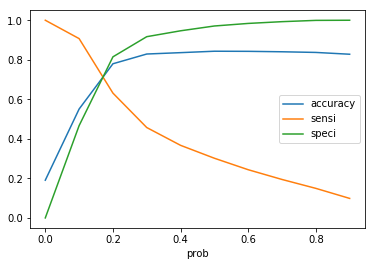

In [61]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [62]:
##### So we see that the optimal cutoff point is 0.17.

In [63]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Default_Prob.map(lambda x: 1 if x > 0.17 else 0)
y_train_pred_final.head()

,Default,Default_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.163658,0,1,1,0,0,0,0,0,0,0,0,0
1,0,0.074914,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.032652,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.003289,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.391188,0,1,1,1,1,0,0,0,0,0,0,1


In [64]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Default, y_train_pred_final.final_predicted)

0.7255607864857381

In [65]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Default, y_train_pred_final.final_predicted )
confusion2

array([[2136,  786],
       [ 205,  484]], dtype=int64)

In [66]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [67]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7024673439767779

In [68]:
# Let us calculate specificity
TN / float(TN+FP)

0.731006160164271

### Step 9: Plotting the ROC Curve

An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [69]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [70]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Default, y_train_pred_final.Default_Prob, drop_intermediate = False )

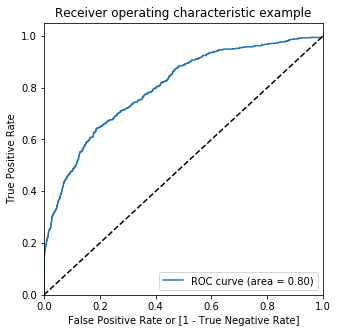

In [71]:
draw_roc(y_train_pred_final.Default, y_train_pred_final.Default_Prob)

#### We see that the area under the curve is 80% and our accuracy,sensitivity and specificity are around 70% so we can say that our model is good and we can run it on the test set

###  Making predictions on the test set

In [72]:
list_=['LOAN','MORTDUE','VALUE','YOJ','DEROG','DELINQ','CLAGE','NINQ','CLNO']

X_test[list_] = scaler.transform(X_test[list_])

C:\Users\shubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\shubh\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [73]:
X_test = X_test[col]
X_test.head()

,YOJ,DEROG,DELINQ,CLAGE,NINQ,JOB_Office,JOB_Sales,JOB_Self
5889,0.097561,0.0,0.000000,0.087567,0.000000,0,0,0
5201,0.219512,0.0,0.000000,0.341030,0.000000,1,0,0
397,0.024390,0.0,0.000000,0.108765,0.153846,0,0,0
66,0.219512,0.0,0.133333,0.173348,0.000000,0,0,0
218,0.097561,0.1,0.000000,0.150080,0.076923,0,1,0


In [74]:
X_test_sm = sm.add_constant(X_test)

Making predictions on the test set

In [75]:
y_test_pred = res.predict(X_test_sm)

In [76]:
y_test_pred[:10]

5889    0.167160
5201    0.012514
397     0.165519
66      0.284577
218     0.428236
2576    0.111894
1976    0.115956
5190    0.095069
2005    0.114759
388     0.273797
dtype: float64

In [77]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

In [78]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [79]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [80]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Default_Prob'})

In [81]:
# Let's see the head of y_pred_final
y_pred_final.head()

,BAD,Default_Prob
5889,0,0.167160
5201,0,0.012514
397,1,0.165519
66,0,0.284577
218,0,0.428236


In [82]:
y_pred_final['final_predicted'] = y_pred_final.Default_Prob.map(lambda x: 1 if x > 0.17 else 0)

In [83]:
y_pred_final.head()

,BAD,Default_Prob,final_predicted
5889,0,0.167160,0
5201,0,0.012514,0
397,1,0.165519,0
66,0,0.284577,1
218,0,0.428236,1


In [84]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.BAD, y_pred_final.final_predicted)

0.6918604651162791

In [85]:
confusion3 = metrics.confusion_matrix(y_pred_final.BAD, y_pred_final.final_predicted )
confusion3

array([[900, 384],
       [ 93, 171]], dtype=int64)

In [86]:
TP = confusion3[1,1] # true positive 
TN = confusion3[0,0] # true negatives
FP = confusion3[0,1] # false positives
FN = confusion3[1,0] # false negatives

In [87]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.6477272727272727

In [88]:
# Let us calculate specificity
TN / float(TN+FP)

0.7009345794392523

##### We see that our model has 80% area under the ROC curve and our accuracy, sensitivity and specificity for the train and test set comes out to be around 69%  so we can say that our model is doing a fair job.